In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 데이터 로드 및 전처리

In [4]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

seed = 1234
np.random.seed(seed)

# 데이터 로드
data_path = '/content/sample_data/Invistico_Airline.csv'
airplane = pd.read_csv(data_path)

# 데이터 자료형에 따른 column 구분

y_column = ['satisfaction']
numeric_columns = ['Age', 'Flight Distance',
                   'Departure Delay in Minutes', 'Arrival Delay in Minutes']
ordinal_columns = ['Seat comfort', 'Departure/Arrival time convenient',
                   'Food and drink', 'Gate location',
                   'Inflight wifi service', 'Inflight entertainment',
                   'Online support', 'Ease of Online booking',
                   'On-board service', 'Leg room service',
                   'Baggage handling', 'Checkin service',
                   'Cleanliness', 'Online boarding']
category_columns = ['Gender', 'Customer Type',
                    'Type of Travel', 'Class']

# na값 제거
airplane_cleaned = airplane.dropna()

# 지연 시간 5시간 이상은 제거
time_limit = 300
airplane_cleaned = airplane_cleaned[(airplane_cleaned['Arrival Delay in Minutes'] < time_limit) &
                                    (airplane_cleaned['Departure Delay in Minutes'] < time_limit)]

# 카테고리형 변수 인코딩
airplane_cate_encoded = pd.get_dummies(airplane_cleaned[category_columns], drop_first=True)
airplane_target_encoded = pd.get_dummies(airplane_cleaned[y_column], drop_first=True)


airplane_combined = pd.concat([airplane_target_encoded,
                               airplane_cleaned[numeric_columns + ordinal_columns],
                               airplane_cate_encoded],
                              axis=1)

# 상관 관계를 바탕으로 15개의 특징만 추출
# 추출할 특징의 이름 ↓
y_column = ['satisfaction_satisfied']
ext_ordinal_columns = ['Inflight entertainment', 'Ease of Online booking',
                       'Online support', 'On-board service',
                       'Online boarding', 'Leg room service',
                       'Checkin service', 'Baggage handling',
                       'Cleanliness', 'Seat comfort',
                       'Inflight wifi service', 'Food and drink']
ext_category_columns = ['Customer Type_disloyal Customer', 'Class_Eco',
                        'Gender_Male']

# 추출된 특징만을 포함할 데이터
ext_airplane_combined = airplane_combined[y_column + ext_ordinal_columns + ext_category_columns]

# 학습 및 평가 데이터 분리
X = ext_airplane_combined.drop(y_column, axis=1)
y = ext_airplane_combined[y_column]
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=42)

In [5]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 60156 entries, 40475 to 15900
Data columns (total 15 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Inflight entertainment           60156 non-null  float64
 1   Ease of Online booking           60156 non-null  float64
 2   Online support                   60156 non-null  float64
 3   On-board service                 60156 non-null  float64
 4   Online boarding                  60156 non-null  float64
 5   Leg room service                 60156 non-null  float64
 6   Checkin service                  60156 non-null  float64
 7   Baggage handling                 60156 non-null  float64
 8   Cleanliness                      60156 non-null  float64
 9   Seat comfort                     60156 non-null  float64
 10  Inflight wifi service            60156 non-null  float64
 11  Food and drink                   60156 non-null  float64
 12  Customer Type_

# SVM


## 추출한 데이터를 활용한 학습

In [6]:
from sklearn.svm import SVC

svm = SVC(kernel='rbf', C=0.1)

In [7]:
%%timeit
svm.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

1min 22s ± 614 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## 학습 SVM 모델을 활용한 예측 및 평가 진행

In [10]:
from sklearn.metrics import accuracy_score
# 예측 수행
y_train_pred_svm = svm.predict(X_train)
y_test_pred_svm = svm.predict(X_test)

# 평가 지표 계산: 정확도 (맞은수/전체)
acc_train = accuracy_score(y_train, y_train_pred_svm)
acc_test = accuracy_score(y_test, y_test_pred_svm)

print(f'학습 데이터를 이용한 SVM Acc 값 : {acc_train*100:.1f}%')
print(f'평가 데이터를 이용한 SVM Acc 값 : {acc_test*100:.1f}%')

학습 데이터를 이용한 SVM Acc 값 : 90.4%
평가 데이터를 이용한 SVM Acc 값 : 90.4%


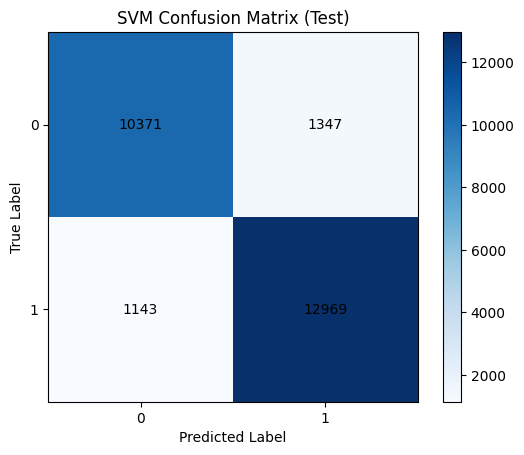

In [ ]:
# confusion matrix을 활용한 평가 결과 확인
cm_test_svm = confusion_matrix(y_test, y_test_pred_svm)

plt.imshow(cm_test_svm, interpolation='nearest', cmap='Blues')
plt.title("SVM Confusion Matrix (Test)")
plt.colorbar()
tick_marks = np.arange(len(np.unique(y_test)))
plt.xticks(tick_marks, np.unique(y_test))
plt.yticks(tick_marks, np.unique(y_test))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

# 각 셀에 숫자 표시
for i in range(cm_test_svm.shape[0]):
    for j in range(cm_test_svm.shape[1]):
        plt.text(j, i, cm_test_svm[i, j], ha="center", va="center", color="black")

In [ ]:
# 정밀도, 재현율, F1 값 비교
from sklearn.metrics import precision_score, recall_score, f1_score

logistic_precision = precision_score(y_test, y_test_pred_logis)
logistic_recall = recall_score(y_test, y_test_pred_logis)
logistic_f1 = f1_score(y_test, y_test_pred_logis)
print(f'Logistic의 P,R,F1 : {logistic_precision:.2f} / {logistic_recall:.2f} / {logistic_f1:.2f}')


svm_precision = precision_score(y_test, y_test_pred_svm)
svm_recall = recall_score(y_test, y_test_pred_svm)
svm_f1 = f1_score(y_test, y_test_pred_svm)
print(f'SVM의 P,R,F1 : {svm_precision:.2f} / {svm_recall:.2f} / {svm_f1:.2f}')

Logistic의 P,R,F1 : 0.84 / 0.85 / 0.84
SVM의 P,R,F1 : 0.91 / 0.92 / 0.91


# Decision Tree 모델을 활용한 학습

## 추출한 데이터를 활용한 학습

In [11]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(criterion='entropy',
                            max_depth=5,
                            min_samples_split=5)

In [ ]:
%%timeit
dt.fit(X_train, y_train)

247 ms ± 10.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


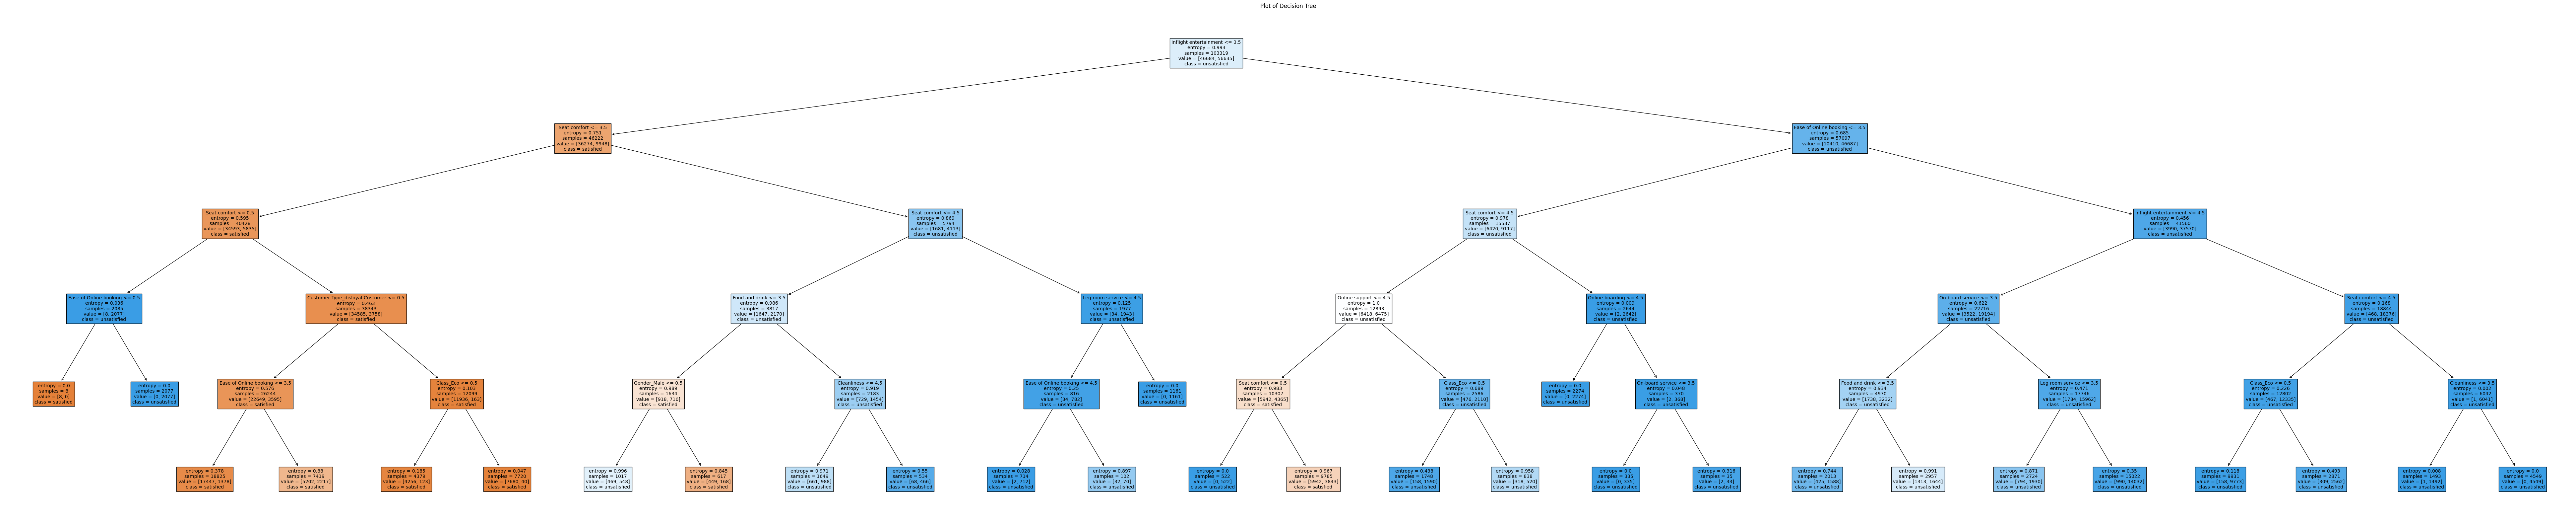

In [ ]:
from sklearn.tree import plot_tree

plt.figure(figsize=(100, 20))
plot_tree(dt, filled=True,
          feature_names=ext_ordinal_columns + ext_category_columns,
          class_names=['satisfied', 'unsatisfied'])
plt.title("Plot of Decision Tree")
plt.show()

## Best model 찾기

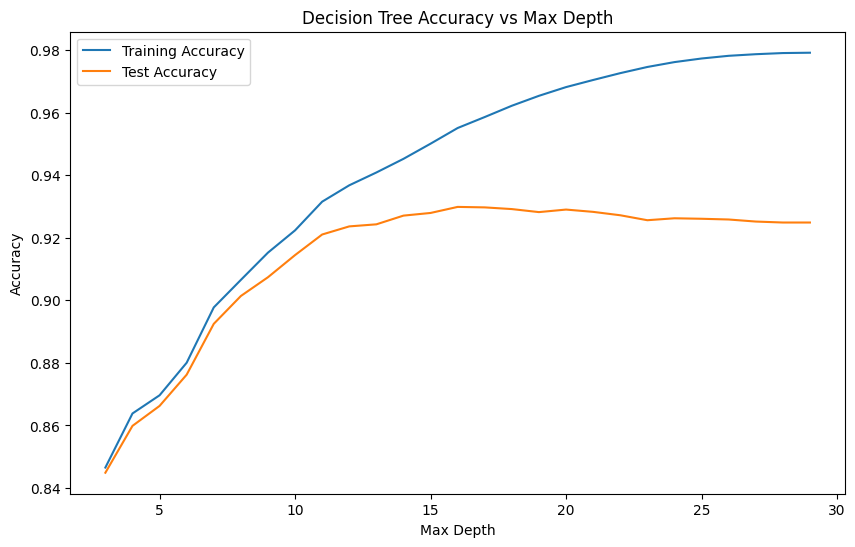

In [ ]:
# max depth에 따른 학습 결과 경향성 파악
max_depths = range(3, 30)

train_accuracies = []
test_accuracies = []

for depth in max_depths:
    model = DecisionTreeClassifier(criterion='entropy',
                                   max_depth=depth,
                                   min_samples_split=5)
    model.fit(X_train, y_train)

    # 학습 데이터에 대한 정확도
    y_train_pred = model.predict(X_train)
    train_acc = accuracy_score(y_train, y_train_pred)
    train_accuracies.append(train_acc)

    # 평가 데이터에 대한 정확도
    y_test_pred = model.predict(X_test)
    test_acc = accuracy_score(y_test, y_test_pred)
    test_accuracies.append(test_acc)

# 결과 시각화
plt.figure(figsize=(10, 6))
plt.plot(max_depths, train_accuracies, label='Training Accuracy')
plt.plot(max_depths, test_accuracies, label='Test Accuracy')
plt.xlabel('Max Depth')
plt.ylabel('Accuracy')
plt.title('Decision Tree Accuracy vs Max Depth')
plt.legend()
plt.show()

In [ ]:
# 최대 정확도를 달성하는 max_depth를 찾고 해당 depth로 최적 모델 학습
max_acc = max(test_accuracies)
best_depth = max_depths[test_accuracies.index(max_acc)]
print('최대 정확도의 depth :', best_depth)

dt = DecisionTreeClassifier(criterion='entropy',
                            max_depth=best_depth,
                            min_samples_split=5)

최대 정확도의 depth : 16


In [ ]:
%%timeit
dt.fit(X_train, y_train)

333 ms ± 4.94 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## 학습 Decision Tree 모델을 활용한 예측 및 평가 진행

In [ ]:
# 예측 수행
y_train_pred_dt = dt.predict(X_train)
y_test_pred_dt = dt.predict(X_test)

# 평가 지표 계산: 정확도 (맞은수/전체)
acc_train = accuracy_score(y_train, y_train_pred_dt)
acc_test = accuracy_score(y_test, y_test_pred_dt)

print(f'학습 데이터를 이용한 DT Acc 값 : {acc_train*100:.1f}%')
print(f'평가 데이터를 이용한 DT Acc 값 : {acc_test*100:.1f}%')

학습 데이터를 이용한 DT Acc 값 : 95.5%
평가 데이터를 이용한 DT Acc 값 : 93.0%


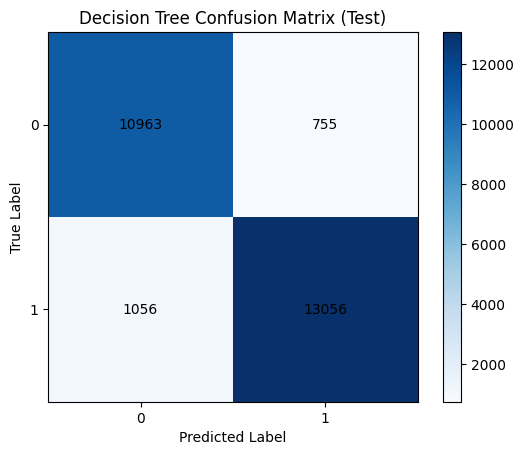

In [ ]:
# confusion matrix을 활용한 평가 결과 확인
cm_test_dt = confusion_matrix(y_test, y_test_pred_dt)

plt.imshow(cm_test_dt, interpolation='nearest', cmap='Blues')
plt.title("Decision Tree Confusion Matrix (Test)")
plt.colorbar()
tick_marks = np.arange(len(np.unique(y_test)))
plt.xticks(tick_marks, np.unique(y_test))
plt.yticks(tick_marks, np.unique(y_test))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

# 각 셀에 숫자 표시
for i in range(cm_test_dt.shape[0]):
    for j in range(cm_test_dt.shape[1]):
        plt.text(j, i, cm_test_dt[i, j], ha="center", va="center", color="black")

In [ ]:
# 정밀도, 재현율, F1 값 비교
from sklearn.metrics import precision_score, recall_score, f1_score

logistic_precision = precision_score(y_test, y_test_pred_logis)
logistic_recall = recall_score(y_test, y_test_pred_logis)
logistic_f1 = f1_score(y_test, y_test_pred_logis)
print(f'Logistic의 P,R,F1 : {logistic_precision:.2f} / {logistic_recall:.2f} / {logistic_f1:.2f}')


svm_precision = precision_score(y_test, y_test_pred_svm)
svm_recall = recall_score(y_test, y_test_pred_svm)
svm_f1 = f1_score(y_test, y_test_pred_svm)
print(f'SVM의 P,R,F1 : {svm_precision:.2f} / {svm_recall:.2f} / {svm_f1:.2f}')


dt_precision = precision_score(y_test, y_test_pred_dt)
dt_recall = recall_score(y_test, y_test_pred_dt)
dt_f1 = f1_score(y_test, y_test_pred_dt)
print(f'DT의 P,R,F1 : {dt_precision:.2f} / {dt_recall:.2f} / {dt_f1:.2f}')

Logistic의 P,R,F1 : 0.84 / 0.85 / 0.84
SVM의 P,R,F1 : 0.91 / 0.92 / 0.91
DT의 P,R,F1 : 0.95 / 0.93 / 0.94
